# AML - VOC 2012

Volpato Mattia 866316

## Imports and utility

In [2]:
from google.colab import drive

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

from tqdm import tqdm
import random
import ast

from sklearn.metrics import confusion_matrix
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam

In [3]:
RANDOM_STATE = 17
N_IMAGES_TO_SHOW = 10
N_CLASSES = 20
IMG_SIZE = (64, 64)

np.random.seed(RANDOM_STATE)
tf.random.set_seed(RANDOM_STATE)
keras.utils.set_random_seed(RANDOM_STATE)

In [4]:
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [5]:
ROOT_DIR = '/content/drive/MyDrive/'
BASE_DIR = ROOT_DIR + 'AML/project/dataset/'

BASE_DIR

'/content/drive/MyDrive/AML/project/dataset/'

In [6]:
TRAIN_IMAGES_DIR = BASE_DIR + 'images/train/'
VALIDATION_IMAGES_DIR = BASE_DIR + 'images/validation/'
TEST_IMAGES_DIR = BASE_DIR + 'images/test/'

TRAIN_IMAGES_DIR, VALIDATION_IMAGES_DIR, TEST_IMAGES_DIR

('/content/drive/MyDrive/AML/project/dataset/images/train/',
 '/content/drive/MyDrive/AML/project/dataset/images/validation/',
 '/content/drive/MyDrive/AML/project/dataset/images/test/')

In [7]:
TRAIN_ANNOTATIONS_PATH = BASE_DIR + 'annotations/train.csv'
VALIDATION_ANNOTATIONS_PATH = BASE_DIR + 'annotations/validation.csv'
TEST_ANNOTATIONS_PATH = BASE_DIR + 'annotations/test.csv'

TRAIN_ANNOTATIONS_PATH, VALIDATION_ANNOTATIONS_PATH, TEST_ANNOTATIONS_PATH

('/content/drive/MyDrive/AML/project/dataset/annotations/train.csv',
 '/content/drive/MyDrive/AML/project/dataset/annotations/validation.csv',
 '/content/drive/MyDrive/AML/project/dataset/annotations/test.csv')

In [11]:
def plot_history(history) -> None:
  fig, axis = plt.subplots(1, 2, figsize=(15, 5))
  fig.tight_layout()

  train_accuracy = history.history['accuracy']
  train_loss = history.history['loss']
  val_accuracy = history.history['val_accuracy']
  val_loss = history.history['val_loss']

  axis[0].set_title('Loss')
  axis[0].set_xlabel('Epochs')
  axis[0].set_ylabel('Loss')
  axis[0].plot(train_loss, label='Training Loss')
  axis[0].plot(val_loss, label='Validation Loss')
  axis[0].legend()

  axis[1].set_title('Accuracy')
  axis[1].set_xlabel('Epochs')
  axis[1].set_ylabel('Accuracy')
  axis[1].plot(train_accuracy, label='Training Accuracy')
  axis[1].plot(val_accuracy, label='Validation Accuracy')
  axis[1].legend()

  plt.show()

In [12]:
def vector_encoding(labels:list[int], num_classes:int):
    class_vector = np.zeros(num_classes)
    for label in labels:
      class_vector[label - 1] = 1
    return class_vector

In [13]:
def load_and_preprocess_image(file_path, label, size=IMG_SIZE):
    try:
      image = tf.io.read_file(file_path)
      image = tf.image.decode_jpeg(image, channels=3)

      image = tf.image.resize(image, size)
      image /= 255.0
    except:
      print(f"Could not load image: {file_path}")

    return image, label

## Preprocessing

### Training set

In [14]:
train_df = pd.read_csv(TRAIN_ANNOTATIONS_PATH)
train_df.head()

,file,classes_id,classes,n_classes
0,2010_005596,"[6, 15]","['bus', 'person']",2
1,2008_000304,[7],['car'],1
2,2008_005726,"[13, 15]","['horse', 'person']",2
3,2009_004432,"[5, 15]","['bottle', 'person']",2
4,2009_003884,"[9, 11]","['chair', 'diningtable']",2


Labels encoding:

In [15]:
train_df["encoded_classes_id"] = train_df["classes_id"].apply(lambda x: vector_encoding(ast.literal_eval(x), N_CLASSES))
train_df

,file,classes_id,classes,n_classes,encoded_classes_id
0,2010_005596,"[6, 15]","['bus', 'person']",2,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ..."
1,2008_000304,[7],['car'],1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ..."
2,2008_005726,"[13, 15]","['horse', 'person']",2,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,2009_004432,"[5, 15]","['bottle', 'person']",2,"[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ..."
4,2009_003884,"[9, 11]","['chair', 'diningtable']",2,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ..."
...,...,...,...,...,...
9227,2008_001932,[15],['person'],1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
9228,2010_002475,[2],['bicycle'],1,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
9229,2010_002752,[3],['bird'],1,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
9230,2008_003160,[3],['bird'],1,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


Visualization of some images:

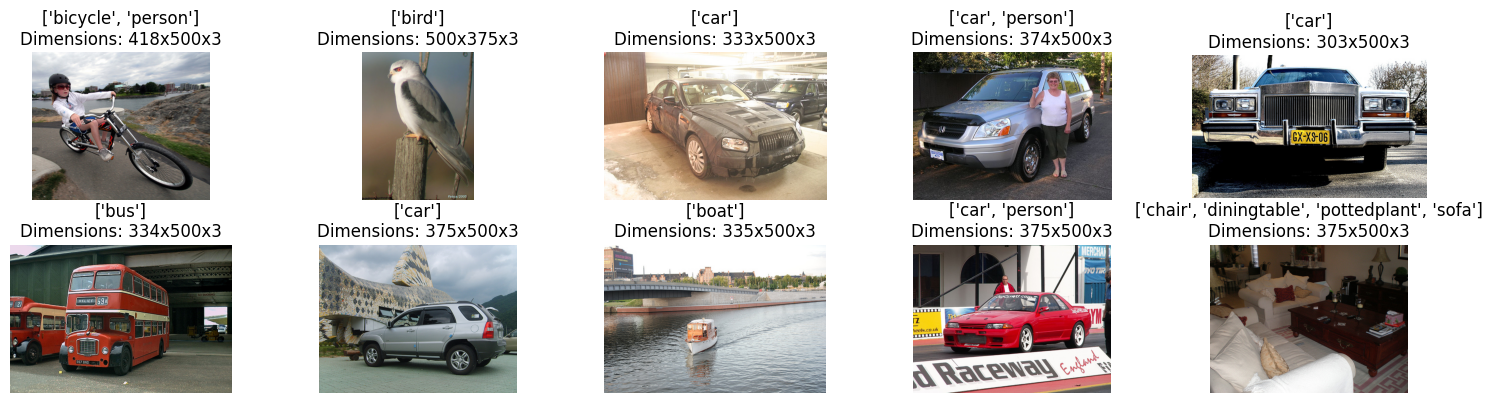

In [16]:
file_rows = train_df.sample(N_IMAGES_TO_SHOW, random_state=RANDOM_STATE)

images = [np.array(Image.open(f"{TRAIN_IMAGES_DIR}{file}.jpg")) for file in file_rows["file"]]
classes = [c for c in file_rows["classes"]]

fig, axes = plt.subplots(2, len(images) // 2, figsize=(15, 4))
fig.tight_layout()

for i, axis in enumerate(axes.flat):
    axis.imshow(images[i], cmap='gray')
    axis.axis('off')
    image_size = images[i].shape
    axis.set_title(f'{classes[i]}\nDimensions: {image_size[0]}x{image_size[1]}x{image_size[2]}')

plt.show()

Visualization of some images after preprocessing:

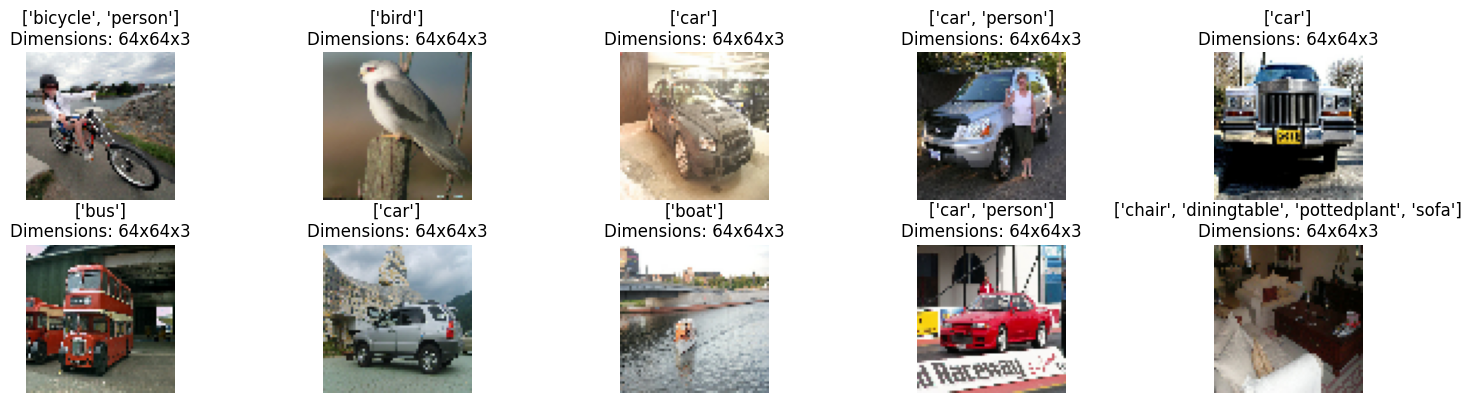

In [17]:
images, classes = zip(*[load_and_preprocess_image(f"{TRAIN_IMAGES_DIR}{row['file']}.jpg", row['classes']) for i, row in file_rows.iterrows()])

fig, axes = plt.subplots(2, len(images) // 2, figsize=(15, 4))
fig.tight_layout()

for i, axis in enumerate(axes.flat):
    axis.imshow(images[i], cmap='gray')
    axis.axis('off')
    image_size = images[i].shape
    axis.set_title(f'{classes[i]}\nDimensions: {image_size[0]}x{image_size[1]}x{image_size[2]}')

plt.show()

Images loading and preprocessing:

In [18]:
train_df["filepath"] = train_df["file"].apply(lambda x: f"{TRAIN_IMAGES_DIR}{x}.jpg")
train_df.head()

,file,classes_id,classes,n_classes,encoded_classes_id,filepath
0,2010_005596,"[6, 15]","['bus', 'person']",2,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...",/content/drive/MyDrive/AML/project/dataset/ima...
1,2008_000304,[7],['car'],1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...",/content/drive/MyDrive/AML/project/dataset/ima...
2,2008_005726,"[13, 15]","['horse', 'person']",2,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",/content/drive/MyDrive/AML/project/dataset/ima...
3,2009_004432,"[5, 15]","['bottle', 'person']",2,"[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...",/content/drive/MyDrive/AML/project/dataset/ima...
4,2009_003884,"[9, 11]","['chair', 'diningtable']",2,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...",/content/drive/MyDrive/AML/project/dataset/ima...


In [19]:
train_labels_array = np.stack(train_df["encoded_classes_id"].values)
train_labels_tensor = tf.convert_to_tensor(train_labels_array, dtype=tf.float32)
train_labels_tensor

<tf.Tensor: shape=(9232, 20), dtype=float32, numpy=
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.]], dtype=float32)>

In [20]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_df["filepath"], train_labels_tensor))
train_dataset = train_dataset.map(load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)

train_dataset

<_ParallelMapDataset element_spec=(TensorSpec(shape=(64, 64, 3), dtype=tf.float32, name=None), TensorSpec(shape=(20,), dtype=tf.float32, name=None))>

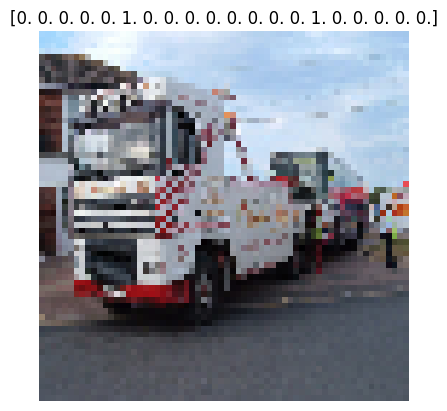

In [29]:
for image, label in train_dataset.take(1):
    image = image.numpy()
    label = label.numpy()
    plt.imshow(image)
    plt.title(f"{label}")
    plt.axis('off')
    plt.show()

Complete preprocessing:

In [22]:
def load_and_preprocess(df:pd.DataFrame, images_folder:str, size:tuple[int, int]=IMG_SIZE, shuffle:bool=False):
    df["encoded_classes_id"] = df["classes_id"].apply(lambda x: vector_encoding(ast.literal_eval(x), N_CLASSES))
    labels_array = np.stack(df["encoded_classes_id"].values)
    labels_tensor = tf.convert_to_tensor(labels_array, dtype=tf.float32)

    df["filepath"] = df["file"].apply(lambda x: f"{images_folder}{x}.jpg")
    dataset = tf.data.Dataset.from_tensor_slices((df["filepath"], labels_tensor))
    dataset = dataset.map(lambda fp, l : load_and_preprocess_image(fp, l, size), num_parallel_calls=tf.data.AUTOTUNE)
    if shuffle:
      dataset = dataset.shuffle(buffer_size=len(dataset), seed=RANDOM_STATE)

    return dataset

In [23]:
train_dataset = load_and_preprocess(train_df, TRAIN_IMAGES_DIR)
train_dataset

<_ParallelMapDataset element_spec=(TensorSpec(shape=(64, 64, 3), dtype=tf.float32, name=None), TensorSpec(shape=(20,), dtype=tf.float32, name=None))>

### Validation set

In [24]:
validation_df = pd.read_csv(VALIDATION_ANNOTATIONS_PATH)
validation_df

,file,classes_id,classes,n_classes
0,2008_002358,[1],['aeroplane'],1
1,2010_003143,"[9, 15, 18]","['chair', 'person', 'sofa']",3
2,2011_002515,"[1, 15]","['aeroplane', 'person']",2
3,2008_001533,"[7, 15]","['car', 'person']",2
4,2009_003663,[8],['cat'],1
...,...,...,...,...
1149,2008_006408,[15],['person'],1
1150,2008_002073,[3],['bird'],1
1151,2008_005758,"[5, 15]","['bottle', 'person']",2
1152,2008_002932,"[2, 15]","['bicycle', 'person']",2


In [25]:
validation_dataset = load_and_preprocess(validation_df, VALIDATION_IMAGES_DIR)
validation_dataset

<_ParallelMapDataset element_spec=(TensorSpec(shape=(64, 64, 3), dtype=tf.float32, name=None), TensorSpec(shape=(20,), dtype=tf.float32, name=None))>

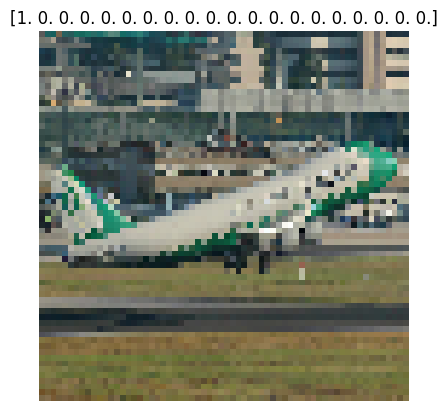

In [28]:
for image, label in validation_dataset.take(1):
    image = image.numpy()
    label = label.numpy()
    plt.imshow(image)
    plt.title(f"{label}")
    plt.axis('off')
    plt.show()

### Trainval set

In [42]:
validation_df["encoded_classes_id"] = validation_df["classes_id"].apply(lambda x: vector_encoding(ast.literal_eval(x), N_CLASSES))
val_labels_array = np.stack(validation_df["encoded_classes_id"].values)
val_labels_tensor = tf.convert_to_tensor(val_labels_array, dtype=tf.float32)

validation_df["filepath"] = validation_df["file"].apply(lambda x: f"{VALIDATION_IMAGES_DIR}{x}.jpg")

train_val_df = pd.concat([train_df, validation_df])
train_val_labels_array = np.stack(train_val_df["encoded_classes_id"].values)
train_val_labels_tensor = tf.convert_to_tensor(train_val_labels_array, dtype=tf.float32)

train_val_dataset = tf.data.Dataset.from_tensor_slices((train_val_df["filepath"], train_val_labels_tensor))
train_val_dataset = train_val_dataset.map(lambda fp, l : load_and_preprocess_image(fp, l, IMG_SIZE), num_parallel_calls=tf.data.AUTOTUNE)

train_val_dataset

<_ParallelMapDataset element_spec=(TensorSpec(shape=(64, 64, 3), dtype=tf.float32, name=None), TensorSpec(shape=(20,), dtype=tf.float32, name=None))>

### Test set

In [30]:
test_df = pd.read_csv(TEST_ANNOTATIONS_PATH)
test_df

,file,classes_id,classes,n_classes
0,2008_001546,[1],['aeroplane'],1
1,2008_001805,[1],['aeroplane'],1
2,2008_002551,[1],['aeroplane'],1
3,2008_003189,[1],['aeroplane'],1
4,2008_004030,[1],['aeroplane'],1
...,...,...,...,...
1149,2010_004857,[20],['tvmonitor'],1
1150,2010_005190,[20],['tvmonitor'],1
1151,2010_005676,[20],['tvmonitor'],1
1152,2011_000382,[20],['tvmonitor'],1


In [31]:
test_dataset = load_and_preprocess(test_df, TEST_IMAGES_DIR)
test_dataset

<_ParallelMapDataset element_spec=(TensorSpec(shape=(64, 64, 3), dtype=tf.float32, name=None), TensorSpec(shape=(20,), dtype=tf.float32, name=None))>

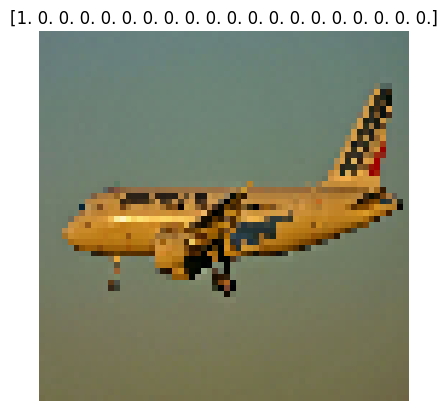

In [32]:
for image, label in test_dataset.take(1):
    image = image.numpy()
    label = label.numpy()
    plt.imshow(image)
    plt.title(f"{label}")
    plt.axis('off')
    plt.show()

## Models

### Custom metrics

Use the **hamming distance** to measure the number of correct and wrong classes predicted for each instance.

In [33]:
def hamming_loss(y_true, y_pred):
    y_pred_binary = tf.cast(y_pred > 0.5, tf.float32)
    loss = tf.reduce_mean(tf.abs(y_true - y_pred_binary))
    return loss

### Base model

In [37]:
def create_base_model(input_shape, num_classes=N_CLASSES, dropout_rate=0.5):
    model = models.Sequential([
        layers.Input(shape=input_shape),
        layers.Dropout(0.2),

        layers.Conv2D(16, (5, 5)),
        layers.LayerNormalization(),
        layers.Activation('relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(dropout_rate),

        layers.Conv2D(16, (5, 5)),
        layers.LayerNormalization(),
        layers.Activation('relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(dropout_rate),

        layers.Conv2D(16, (5, 5)),
        layers.LayerNormalization(),
        layers.Activation('relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(dropout_rate),

        layers.Flatten(),
        layers.Dense(8, activation='relu'),
        layers.Dropout(0.5),

        layers.Dense(num_classes, activation='sigmoid')
    ])

    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='binary_crossentropy',
                  metrics=['accuracy', hamming_loss])

    return model

model = create_base_model(input_shape=(64, 64, 3))
model.summary()


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dropout_16 (Dropout)                 │ (None, 64, 64, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 60, 60, 16)          │           1,216 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ layer_normalization_10               │ (None, 60, 60, 16)          │              32 │
│ (LayerNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_10 (Activation)           │ (None, 60, 60, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 30, 30, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_17 (Dropout)                 │ (None, 30, 30, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 26, 26, 16)          │           6,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ layer_normalization_11               │ (None, 26, 26, 16)          │              32 │
│ (LayerNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_11 (Activation)           │ (None, 26, 26, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 13, 13, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_18 (Dropout)                 │ (None, 13, 13, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_12 (Conv2D)                   │ (None, 9, 9, 16)            │           6,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ layer_normalization_12               │ (None, 9, 9, 16)            │              32 │
│ (LayerNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_12 (Activation)           │ (None, 9, 9, 16)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 4, 4, 16)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_19 (Dropout)                 │ (None, 4, 4, 16)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 8)                   │           2,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_20 (Dropout)                 │ (None, 8)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 20)                  │             1

 Total params: 16,380 (63.98 KB)

 Trainable params: 16,380 (63.98 KB)

 Non-trainable params: 0 (0.00 B)

In [38]:
BATCH_SIZE = 8

In [39]:
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
validation_dataset = validation_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

train_dataset, validation_dataset

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None))>)

In [40]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
early_stopping

In [43]:
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=100,
    callbacks=[early_stopping]
)

Epoch 1/100


NotFoundError: Graph execution error:

Detected at node StatefulPartitionedCall defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "/usr/local/lib/python3.11/dist-packages/colab_kernel_launcher.py", line 37, in <module>

  File "/usr/local/lib/python3.11/dist-packages/traitlets/config/application.py", line 992, in launch_instance

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelapp.py", line 619, in start

  File "/usr/local/lib/python3.11/dist-packages/tornado/platform/asyncio.py", line 195, in start

  File "/usr/lib/python3.11/asyncio/base_events.py", line 608, in run_forever

  File "/usr/lib/python3.11/asyncio/base_events.py", line 1936, in _run_once

  File "/usr/lib/python3.11/asyncio/events.py", line 84, in _run

  File "/usr/local/lib/python3.11/dist-packages/tornado/ioloop.py", line 685, in <lambda>

  File "/usr/local/lib/python3.11/dist-packages/tornado/ioloop.py", line 738, in _run_callback

  File "/usr/local/lib/python3.11/dist-packages/tornado/gen.py", line 825, in inner

  File "/usr/local/lib/python3.11/dist-packages/tornado/gen.py", line 786, in run

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py", line 361, in process_one

  File "/usr/local/lib/python3.11/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py", line 261, in dispatch_shell

  File "/usr/local/lib/python3.11/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py", line 539, in execute_request

  File "/usr/local/lib/python3.11/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py", line 302, in do_execute

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/zmqshell.py", line 539, in run_cell

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 2975, in run_cell

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3030, in _run_cell

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3257, in run_cell_async

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3473, in run_ast_nodes

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code

  File "<ipython-input-41-9e5aa85d3bd0>", line 1, in <cell line: 0>

  File "/usr/local/lib/python3.11/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py", line 320, in fit

  File "/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py", line 121, in one_step_on_iterator

could not find registered transfer manager for platform Host -- check target linkage
	 [[{{node StatefulPartitionedCall}}]] [Op:__inference_one_step_on_iterator_4729]

In [ ]:
plot_history(history)